In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [2]:
plt.rcParams.update({'figure.figsize': [12, 5], 'figure.dpi': 80,
                     'figure.facecolor': 'white'})
plt.style.use('seaborn-whitegrid')

### Generating data

This is a generated dataset with 3 actors: most of their data fall appear in the first cluster, around the zero, however, the first actor has ~1/5 of the data in another cluster around 2, and the second actor has wider spread data around 1 and 3. In the figure below they are represented with blue and yellow respectively. The third actor (green) does not have a secondary cluster.

In [3]:
data = pd.concat(
    [
        pd.DataFrame(dict(
            v = pm.Lognormal.dist(mu=-2.5, sd=1).random(size=3000),
            actor_i = [0] * 3000
        )),
        pd.DataFrame(dict(
            v = pm.Lognormal.dist(mu=-2.2, sd=.9).random(size=4000),
            actor_i = [1] * 4000
        )),
        pd.DataFrame(dict(
            v = pm.Lognormal.dist(mu=-2.6, sd=1.1).random(size=5000),
            actor_i = [2] * 5000
        )),
        pd.DataFrame(dict(
            v = pm.Lognormal.dist(mu=np.log(3), sd=0.2).random(size=750),
            actor_i = [0] * 750
        )),
        pd.DataFrame(dict(
            v = pm.Lognormal.dist(mu=np.log(2), sd=0.6).random(size=300),
            actor_i = [1] * 300
        )),
    ],
    ignore_index=True
)

data = data.sample(frac=1).reset_index(drop=True)
display(data.shape[0])
data.sample(5)

13050

,v,actor_i
10583,0.202383,2
9308,0.045905,2
10272,0.043230,0
4808,0.110442,0
561,0.017687,2


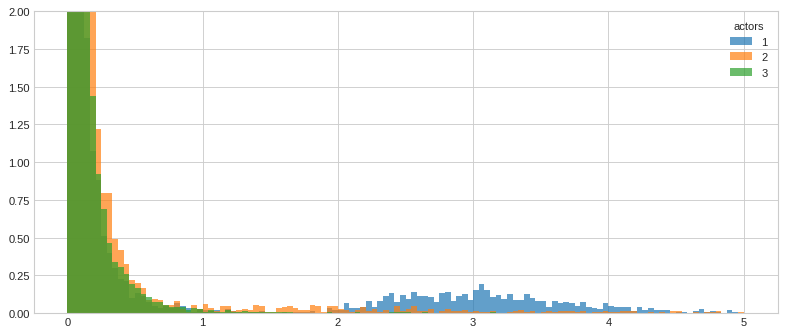

In [4]:
for i in range(3):
    tmp = data[data.actor_i == i]
    plt.hist(tmp.v, bins=np.linspace(0, 5, 121),
             density=True, alpha=.7, label=i + 1),
plt.gca().set(ylim=(0, 2))
plt.legend(title='actors')
None

## Mixture model


$$ \text{observed} \sim \text{Mixture}(\text{weights}=[w_{\text{well_behaved}}, w_{\text{anomalous}_i}], [\text{well_behaved_dist},  \text{anomalous_dist}_i ] ) $$

All actors share the same distribution for the good behaviour:

$$ \text{well_behaved_dist} \sim \text{Lognormal}(\mu_0, \sigma_0^2) $$

All anomalous distributions are unique to the actors:

$$ \text{anomalous_dist}_{i} \sim \text{Lognormal}(\mu_{1, i}, \sigma_{1, i}^2) $$

$$ \mu_{1, i} = \mu_{1, actor_i}, \sigma_{1, i} = \sigma_{1, actor_i}$$

Priors on the well-behaved distribution:

$$ \mu_0 \sim \text{Normal}(0, 3^2) $$

$$ \sigma_0 \sim \text{Exponential}(\tfrac{1}{2}) $$

Priors on the anomalous distribution. We will bound the clusters to not appear on locations below 0.5:

$$ \mu_{actor} \sim \text{Normal}(0, 3^2, \text{lower}=\log 0.5) $$

$$ \sigma_{actor} ~ \sim \text{HalfCauchy}(1) $$

From the properties of the lognormal distribution, the locations of the anomalous clusters per actor appear at:

$$ \exp(\mu_{1, actor}  + \tfrac{\sigma_{1, actor}}{2}  )$$

As we expect the anomalous behaviour to appear much less often, we will put the following prior on the **incidence rate**:

$$ \alpha_{actor} \sim \text{Beta}(3, 1) $$

And the weights will follow from:

$$  w_{\text{anomalous}_i} = \alpha_{actor_i} $$

$$ w_{\text{well_behaved}} = 1 - w_{\text{anomalous}} $$ 

In [9]:
with pm.Model() as m1:
    n_actors = data.actor_i.nunique()
    N = data.shape[0]

    mu0 = pm.Normal('mu0', mu=0, sd=3)
    sd0 = pm.Exponential('sd0', lam=1/2.)
    well_behaved = pm.Lognormal.dist(mu0, sd0, shape=N)

    mu1 = pm.Bound(pm.Normal, lower=-0.6)('mu1', mu=0., sd=3, shape=n_actors)
    sd1 = pm.HalfCauchy('sd1', beta=1, shape=n_actors)

    mu_i = pm.Deterministic('mu_i', mu1[data.actor_i.values])
    sd_i = pm.Deterministic('sd_i', sd1[data.actor_i.values])
    anomalous = pm.Lognormal.dist(mu=mu_i, sd=sd_i)

    alpha = pm.Beta('alpha', 3, 1, shape=n_actors)
    alpha_i = alpha[data.actor_i.values]

    w = pm.math.stack([alpha_i, 1 - alpha_i]).T

    # log-probabilities of the individual mixture components,
    # evaluated on the observed values
    logpcomp = tt.stack([anomalous.logp(data.v.values), well_behaved.logp(data.v.values)]).T

    # inference with mixture
    pm.Potential('logp', pm.logsumexp(tt.log(w) + logpcomp, axis=-1).sum())

    loc1 = pm.Deterministic('loc1', pm.math.exp(mu1 + sd1 / 2))

    m1.trace = pm.sample(7000, tune=15000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, sd1, mu1, sd0, mu0]
Sampling 2 chains, 5 divergences: 100%|██████████| 44000/44000 [29:08<00:00, 12.58draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [10]:
pm.summary(m1.trace, var_names=['mu0', 'sd0', 'mu1', 'sd1', 'alpha', 'loc1'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,-2.485,0.011,-2.504,-2.464,0.000,0.000,8372.0,8372.0,8366.0,7376.0,1.0
sd0,1.005,0.008,0.991,1.021,0.000,0.000,9191.0,9180.0,9204.0,8209.0,1.0
mu1[0],1.106,0.007,1.092,1.120,0.000,0.000,11051.0,11050.0,11055.0,8265.0,1.0
mu1[1],-0.555,0.044,-0.600,-0.475,0.001,0.000,6480.0,6357.0,5059.0,4283.0,1.0
mu1[2],-0.153,0.345,-0.600,0.468,0.005,0.004,4295.0,4295.0,4787.0,3157.0,1.0
sd1[0],0.202,0.005,0.192,0.212,0.000,0.000,10874.0,10842.0,10899.0,8267.0,1.0
sd1[1],1.289,0.042,1.209,1.367,0.000,0.000,9194.0,9153.0,9243.0,5894.0,1.0
sd1[2],0.640,0.301,0.167,1.040,0.004,0.003,4483.0,4483.0,4222.0,2154.0,1.0
alpha[0],0.201,0.006,0.189,0.213,0.000,0.000,9823.0,9818.0,9829.0,7688.0,1.0
alpha[1],0.183,0.012,0.162,0.205,0.000,0.000,7104.0,7104.0,7184.0,6463.0,1.0


For the first actor, both the incidence rate ($\alpha$) and the location were infered very well. No anomalour cluster was correctly found for the third actor.

For the second actor, however, the incidence rate was overestimated. We can overcome this issue if we add strict boundaries on the likelihood distributions themselves.

In [13]:
with pm.Model() as m2:
    n_actors = data.actor_i.nunique()
    N = data.shape[0]

    mu0 =pm.Bound(pm.Normal, upper=0.4)('mu0', mu=0, sd=3)
    sd0 = pm.Exponential('sd0', lam=1/2.)
    well_behaved = pm.Bound(pm.Lognormal, upper=1.5).dist(mu0, sd0)

    mu1 = pm.Bound(pm.Normal, lower=-0.6)('mu1', mu=0., sd=3, shape=n_actors)
    sd1 = pm.HalfCauchy('sd1', beta=1, shape=n_actors)

    mu_i = pm.Deterministic('mu_i', mu1[data.actor_i.values])
    sd_i = pm.Deterministic('sd_i', sd1[data.actor_i.values])
    anomalous = pm.Bound(pm.Lognormal, lower=0.5).dist(mu=mu_i, sd=sd_i)

    alpha = pm.Beta('alpha', 3, 1, shape=n_actors)
    alpha_i = alpha[data.actor_i.values]

    w = pm.math.stack([alpha_i, 1 - alpha_i]).T

    logpcomp = tt.stack([anomalous.logp(data.v.values), well_behaved.logp(data.v.values)]).T
    pm.Potential('logp', ( pm.logsumexp(tt.log(w) + logpcomp, axis=-1)).sum())     

    loc1 = pm.Deterministic('loc1', pm.math.exp(mu1 + sd1 / 2))

    m2.trace = pm.sample(7000, tune=10000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, sd1, mu1, sd0, mu0]
Sampling 2 chains, 4 divergences: 100%|██████████| 34000/34000 [11:28<00:00, 27.42draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
pm.summary(m2.trace, var_names=['mu0', 'sd0', 'mu1', 'sd1', 'alpha', 'loc1'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,-2.156,1.840,-5.419,0.399,0.016,0.011,13185.0,13185.0,9048.0,5361.0,1.0
sd0,0.000,0.000,0.000,0.000,0.000,0.000,15525.0,10611.0,14293.0,7992.0,1.0
mu1[0],1.104,0.007,1.090,1.118,0.000,0.000,18468.0,18458.0,18499.0,9988.0,1.0
mu1[1],0.996,0.029,0.944,1.054,0.000,0.000,15007.0,15000.0,14999.0,8974.0,1.0
mu1[2],0.693,0.062,0.579,0.809,0.001,0.000,14164.0,14164.0,14404.0,8774.0,1.0
sd1[0],0.204,0.005,0.194,0.214,0.000,0.000,20151.0,19998.0,20399.0,9921.0,1.0
sd1[1],0.439,0.021,0.401,0.479,0.000,0.000,15981.0,15721.0,16276.0,9136.0,1.0
sd1[2],0.250,0.050,0.165,0.342,0.000,0.000,13295.0,11738.0,15824.0,9754.0,1.0
alpha[0],0.202,0.006,0.189,0.213,0.000,0.000,18592.0,18571.0,18588.0,10272.0,1.0
alpha[1],0.055,0.004,0.049,0.062,0.000,0.000,19966.0,19630.0,20016.0,9523.0,1.0


All the incidence rates are now properly estimated, although the location of the second cluster is not - that one has a high spread.

The estimation should get better once there are more clusters, as the location of the normal behaviour will be easily infered and there will not be a reason for the hard boundary conditions.